# Introduction

This notebook assumes you have activated credentials with the CAVE client. CAVE (Connectome Annotation Versioning Engine) is built and supported by a collaboration between the Seung lab at Princeton and the Allen Institute for Brain Science. It allows for programmatic access to the tables associated with Minnie and other datasets. [Github](https://github.com/seung-lab/CAVEclient) 

CAVE setup instructions are [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/CAVEsetup.ipynb).

CAVE tutorial for querying the data is [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

## Using CAVEclient to query data

In [1]:
from caveclient import CAVEclient

Load the public client for accessing the datastack in CAVE. If you have not acquired an authentication token, run the code below to get a new token. You will need to link your Google account.

In [2]:
# client = CAVEclient()
# client.auth.get_new_token()

If you have successfully added your token or already have a valid token saved from a previous session, you should be able to initialize the client with the `minnie65_public_v343` datastack:

```python
client = CAVEclient('minnie65_public_v343')
```

If your previous saved token is invalidated, you will need to save your newly acquired token with the argument `overwrite=True`.

```python
client.auth.save_token(token="PASTE_YOUR_TOKEN_HERE", overwrite=True)
```

In [3]:
# this is the datastack name of the public release
# passing it will auto-configure many of the services
client = CAVEclient('minnie65_public_v343')

### View available annotation tables

In [4]:
client.materialize.get_tables()

['synapses_pni_2',
 'nucleus_neuron_svm',
 'nucleus_detection_v0',
 'functional_coreg',
 'allen_v1_column_types_slanted',
 'aibs_column_nonneuronal',
 'func_unit_em_match_release',
 'proofreading_status_public_release',
 'aibs_soma_nuc_metamodel_preds_v117']

### Query functionally matched EM neurons

In [5]:
import pandas as pd

In [6]:
matched_df = client.materialize.query_table('functional_coreg')
matched_df

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
0,1,t,102531727972419182,864691136136642173,4,7,665,"[274864, 94064, 22046]"
1,2,t,94792540099826672,864691136208993724,4,7,740,"[218320, 104320, 19016]"
2,4,t,93946810036875732,864691135683934135,4,7,782,"[212128, 94544, 23423]"
3,5,t,84730565597057981,864691135334528233,4,7,855,"[145158, 110036, 19355]"
4,6,t,110905058841147285,864691136309730650,4,7,921,"[335744, 90128, 22805]"
...,...,...,...,...,...,...,...,...
9513,9310,t,90010557939512630,864691135502196829,9,4,7556,"[183528, 127304, 19684]"
9514,8479,t,96484208197075426,864691135569353862,7,3,1827,"[230543, 125587, 24830]"
9515,7837,t,86631484635009955,864691135925955086,5,6,2592,"[158839, 117248, 26051]"
9516,8718,t,96906420528106308,864691135082076407,8,5,1859,"[234005, 125493, 23956]"


### Column descriptions:

<b>id:</b> a unique identifier for this row

<b>valid:</b> internal check, uniformly ‘t’

<b>pt_supervoxel_id:</b> the ID of the supervoxel from the watershed segmentation that is under the pt_position

<b>pt_root_id:</b> the ID of the segment/root_id under the pt_position from the Proofread Segmentation (v343).

<b>session:</b> the ID indicating the imaging period for the mouse

<b>scan_idx:</b> the index of the scan within the imaging session

<b>unit_id:</b> the ID of the functional ROI (unique per scan)

<b>pt_position_{x,y,z}:</b> the location in 4,4,40 nm voxels at a cell body for the cell

### Select a random entry

In [7]:
entry = matched_df.sample(1)
entry

,id,valid,pt_supervoxel_id,pt_root_id,session,scan_idx,unit_id,pt_position
1168,1242,t,112884730063646459,864691135760541629,6,6,6198,"[349776, 159728, 26739]"


In [8]:
segment = entry.pt_root_id.values[0] # get ID of segment to visualize
centroid = entry.pt_position.values[0] # get centroid of segment

## View entry in Neuroglancer

Programmatic editing of Neuroglancer links can be accomplished using the Seung lab/ AIBS package [nglui](https://github.com/seung-lab/NeuroglancerAnnotationUI).

```python
pip install nglui
```

[Example notebook](https://github.com/seung-lab/NeuroglancerAnnotationUI/blob/master/examples/statebuilder_examples.ipynb)

In [9]:
# generate links in Seung lab a custom Neuroglancer deployment called Neuromancer
from nglui import statebuilder, EasyViewer 

viewer = EasyViewer()
viewer.set_resolution((4,4,40))

em_layer = statebuilder.ImageLayerConfig(client.info.image_source(), 
                                         contrast_controls=True, black=0.35, white=0.7) # set EM layer 
seg_layer =  statebuilder.SegmentationLayerConfig(client.info.segmentation_source(),  
                                                  name='seg', fixed_ids=[segment]) # set dynamic segmentation layer
view_kws = {'layout': '3d',
            'zoom_3d': 3000,
            'position': centroid}  # set zoom options and center on segment

sb = statebuilder.StateBuilder([em_layer, seg_layer], view_kws=view_kws) # generate statebuilder
sb.render_state(return_as='html', base_state=viewer.state) # render state as html link


# Access Functional data

This notebook assumes you have access to a copy of the SQL database that houses the functional data and the functional data schema repository. Instructions to download are [here](https://www.microns-explorer.org/cortical-mm3#f-data).

The contents of the SQL schema are accessed programmatically using [DataJoint](https://datajoint.io/). Find an example notebook for using DataJoint to access the functional data [here].

In [10]:
%%capture
import datajoint as dj
import sys
sys.path.append('..')
from microns_phase3 import nda
from microns_phase3.utils import fetch_oracle_raster

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Convert entry to DataJoint compatible key

DataJoint tables can be restricted with dictionaries. Here we generate a dictionary of attributes that specify the unique functional ROI in the DataJoint schema. 

In [11]:
unit_key = entry[['session', 'scan_idx', 'unit_id']].to_dict(orient='records')[0]
unit_key

{'session': 6, 'scan_idx': 6, 'unit_id': 6198}

### Fetch & plot activity trace, calcium trace, pupil radius, and treadmill

Here we use the key to fetch and plot a variety of data from the schema, including the unit's calcium & spike traces, and the scan's pupil trace and treadmill speed. 

Note: The `nda.ManualPupil` and `nda.Treadmill` tables only contain the `session` and `scan_idx` attributes, but can still be retrieved with the `unit_key`. The `unit_id` attribute is ignored when restricting against these tables.

In [12]:
nframes, fps = (nda.Scan & unit_key).fetch1('nframes', 'fps')  # fetch # frames and fps
time_axis = np.arange(nframes)/ fps # create time axis (seconds)
spike_trace = (nda.Activity & unit_key).fetch1('trace') # fetch spike trace
calcium_trace = (nda.ScanUnit * nda.Fluorescence & unit_key).fetch1('trace') # fetch calcium fluorescence trace
pupil_radius = (nda.ManualPupil & unit_key).fetch1('pupil_maj_r') # fetch manually segmented pupil trace 
treadmill = (nda.Treadmill & unit_key).fetch1('treadmill_velocity') # fetch treadmill speed

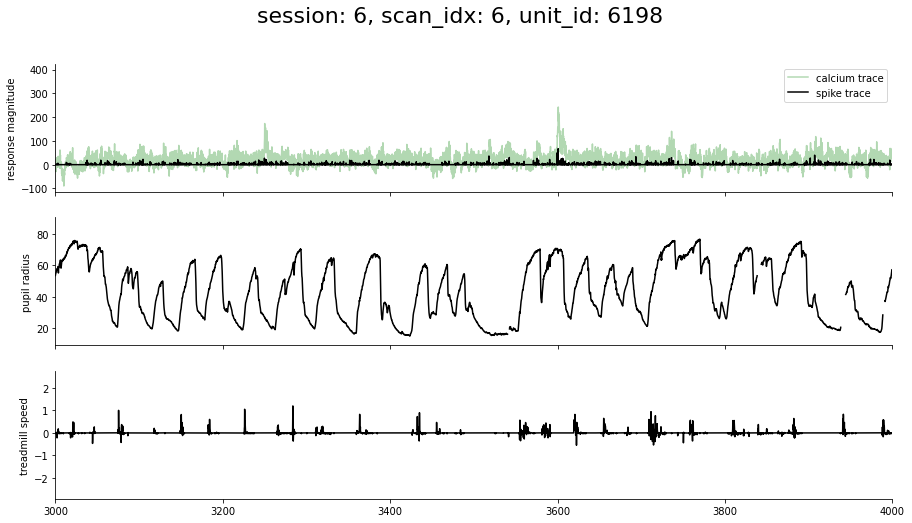

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 8), sharex=True)
ax1.plot(time_axis, calcium_trace, color='g', alpha=0.3, label='calcium trace')
ax1.plot(time_axis, spike_trace, color='k', label='spike trace')
ax2.plot(time_axis, pupil_radius, color='k')
ax3.plot(time_axis, treadmill, color='k')
ax3.set_xlim(3000, 4000) 
ax1.set_ylabel('response magnitude')
ax1.legend()
ax2.set_ylabel('pupil radius')
ax3.set_ylabel('treadmill speed')
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=22);
[ax.spines['right'].set_visible(False) for ax in [ax1, ax2, ax3]];
[ax.spines['top'].set_visible(False) for ax in [ax1, ax2, ax3]];

### Plot oracle raster

Here we use a function provided in the `utils` module to retrieve the responses for the functional unit for the repeated stimulus trials (oracle trials). For a further description of the oracle see the technical documentation.

In [14]:
oracle_traces, score = fetch_oracle_raster(unit_key)

Text(0.5, 1.2, 'session: 6, scan_idx: 6, unit_id: 6198')

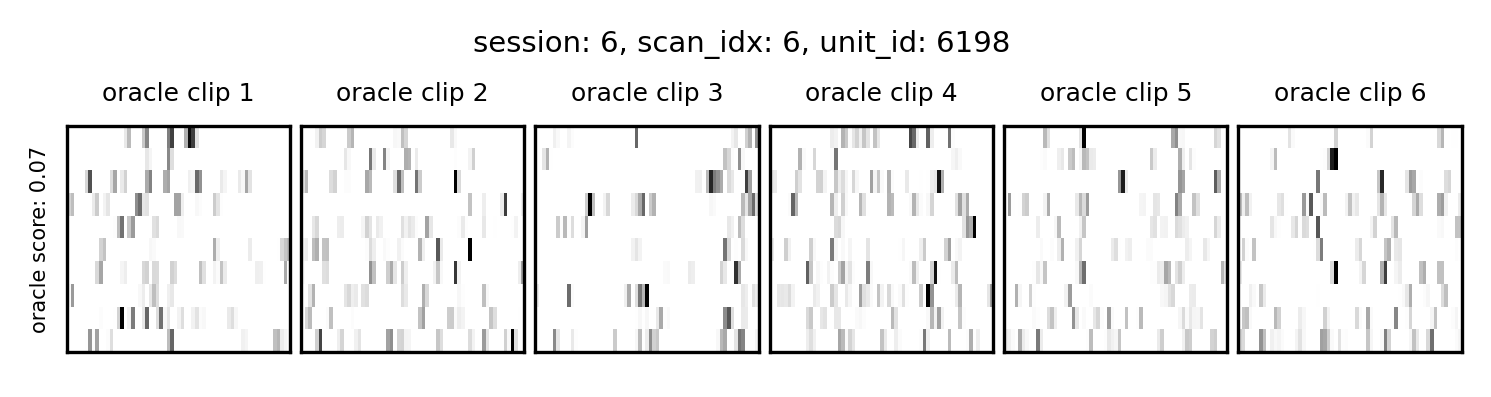

In [15]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)